# Quantum reservoir computing (QRC) for stock prediction

The main advantage of Reservoir Computing (RC), compared to traditional Neural Networks (NNs), is the simplicity of the learning model, which usually only requires training a linear regression model. To this end, classical RC uses a network with fixed random weights to learn the input-output dynamics. In contrast, Quantum Reservoirs (QRs) are quantum systems with random parameters, which are used to learn from the input data.

The motivation for using quantum devices lies in the large number of degrees of freedom of quantum systems. A quantum system with $N$ qubits has a Hilbert space of size $2^N$, which means that quantum states have the potential to encode exponentially larger data than classical systems. Moreover, even though quantum computers suffer from noise and decoherence, the easy training strategy of QRC makes it a suitable algorithm for NISQ devices.

In this notebook, we are going to use QRC to forecast the prices of stock prices. We will see that this is a very challenging task!

Let's start by importing the necessary python packages.



Run the following three cells if you are using Google Colab

In [29]:
!git clone https://github.com/laiadc/QML.git

Cloning into 'QML'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 98 (delta 36), reused 98 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 20.00 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [30]:
cd QML/QRC\ tutorial

/content/QML/QRC tutorial/QML/QRC tutorial


In [31]:
pip install -r requirements.txt

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit_aer import Aer
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import DensityMatrix, Pauli, Operator, SparsePauliOp
from qiskit.quantum_info.states.utils import partial_trace
import qiskit

# Sklearn imports
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Loading the data

The first step is to load the stocks data. LEt's load the `stocks_daily.csv` file and take a look at it.

In [33]:
data =pd.read_csv('stocks_daily.csv', on_bad_lines='warn')
data.Datetime = pd.to_datetime(data.Datetime)
data.head()

,Datetime,Close,High,Low,Open,Volume,symbol,EMA,MACD,ADX,...,volatility,ATR,Bands_width,price_range,volume_trend,volume_EMA7,OBV,RSI,SO,PROC
0,2018-02-01,41.945000,42.154999,41.689999,41.792500,188923200.0,AAPL,41.945000,0.000000,100.000000,...,1.502985,1.919998,0.204057,0.011154,0.833418,1.889232e+08,0.0,0.000000,91.571601,4.321135
1,2018-02-02,40.125000,41.700001,40.025002,41.500000,346375200.0,AAPL,40.997083,-0.022685,100.000000,...,1.502985,1.919998,0.204057,0.041849,0.833418,2.788958e+08,-346375200.0,0.000000,91.571601,4.321135
2,2018-02-05,39.122501,40.970001,39.000000,39.775002,290954000.0,AAPL,40.319458,-0.047452,100.000000,...,1.502985,1.970001,0.204057,0.050513,-0.160003,2.841101e+08,-637329200.0,0.000000,91.571601,4.321135
3,2018-02-06,40.757500,40.930000,38.500000,38.707500,272975200.0,AAPL,40.443021,-0.045362,100.000000,...,1.502985,2.430000,0.204057,0.063117,-0.061793,2.800379e+08,-364354000.0,39.899955,91.571601,4.321135
4,2018-02-07,39.884998,40.849998,39.767502,40.772499,206434400.0,AAPL,40.312075,-0.047455,106.151205,...,1.502985,1.082497,0.204057,0.027221,-0.243761,2.559118e+08,-570788400.0,32.401125,91.571601,4.321135


You can see that there are many columns. The price that we will be interested in is the `Close` price, which corresponds to the price achieved at the end of the day. You can see that the dataset contains other prices that happened during the day (`High`, `Low`, `Open`) and some technical indicators that can be useful to make future predictions. The column `symbol` provides the name of the stock. In this example, we will focus on forecasting the prices of the AMAZON stock.

## Preprocessing

The first step is to process the raw dataset. We will select the Close price of the Amazon stock and split it into training, validation and test sets. Remember that the training set is used to train the model, the validation set is used to evaluate different predictive models and select the most optimal one, and the test set provides an estimation of the final performance.

The last step will be to scale the data to the $[0,1]$ domain. This is necessary to give the input data to the quantum reservoir, as we will see later.

Text(0.5, 1.0, 'AMAZON stock prices')

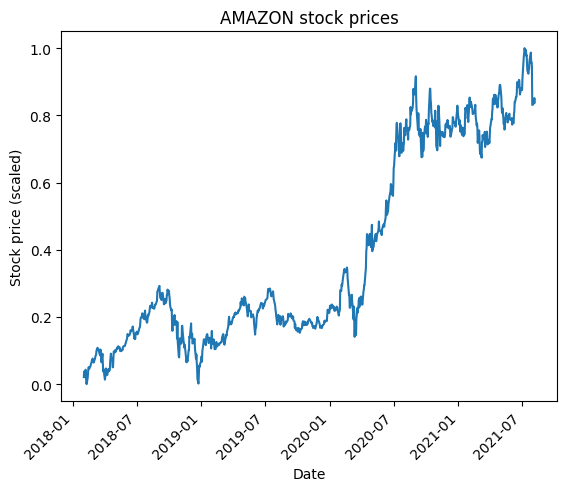

In [34]:
# Select series to analyze
y = data.Close[data.symbol=='AMZN']
time = data.Datetime[data.symbol=='AMZN'].values

# Separate into training, validation and test
dateIn_val = np.datetime64("2021-08-08")
dateFin_val = np.datetime64("2022-04-21")

y_train = y[time<=dateIn_val].values
y_val = y[(time>dateIn_val) & (time<dateFin_val)].values
y_test = y[time>dateFin_val].values

date_train = time[time<=dateIn_val]
date_val = time[(time>dateIn_val) & (time<dateFin_val)]
date_test = time[time>dateFin_val]

# Scale data to (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1)).reshape(-1)
y_val_scaled = scaler.transform(np.array(y_val).reshape(-1,1)).reshape(-1)
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1)).reshape(-1)

# Let's make sure that the data is between (0,1) in the validation and test sets
y_test_scaled[y_test_scaled<0]=0
y_test_scaled[y_test_scaled>1]=1
y_val_scaled[y_val_scaled<0]=0
y_val_scaled[y_val_scaled>1]=1


plt.plot(date_train, y_train_scaled)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Stock price (scaled)')
plt.title('AMAZON stock prices')

## Quantum reservoir computing
The idea of QRC lies in using a Hilbert space, where quantum states live, as an enhanced feature space of the input data. In this way, the extracted features enhanced by quantum operations are used to feed a classical machine learning model, which predicts the desired target.  Consider the dataset $\{(\vec{x},\vec{y})_i\}$. The first step for designing a QR is selecting a data encoding method, which maps the input data into a quantum circuit. By convention, the initial state of the quantum system is always $\ket{0}^{\otimes n}$. The data encoding process maps

\begin{equation}
    \ket{0}^{\otimes n} \rightarrow V(\vec{x})\ket{0}^{\otimes n},
\end{equation}


where $V(x)$ is a unitary transformation that depends on the input sample $x$. There are multiple ways to design the data encoding mapping. If the input data is a normalized vector $\vec{x}= (x_1, \cdots, x_n), \ x_i \in [0,1]$, then a popular data encoding method generates a $N>n$ qubits state where the first $n$ qubits would be initialized, at each time step $t$ as

\begin{equation}
    \ket{y(t)} = (\sqrt{1-y(t)_i}\ket{0} + \sqrt{y(t)_i}\ket{1})^{\otimes 1 \cdots n},
\end{equation}

and the full, $N$-qubit state is

\begin{equation}
    \rho(t) = \ket{y(t)}\bra{y(t)} \otimes Tr_n\Big(\rho(t-\Delta t)\Big),
\end{equation}


where $y(t)_i$ is the $i$-th component of the time series, and the partial trace $Tr_n(\cdot)$ is done on the first $n$ qubits. Notice that we require $N>n$ so that the state at time $t$ has information from its past states. The first $n$ qubits are used to encode the data, and the remaining $N - n$ qubits are used to gather information from the previous values of the time series, which is captured by the partial trace



After encoding the quantum state at time $t$, the system evolves under a unitary transformation $U$ until time $t + \Delta t$. The unitary transformation can be a quantum circuit, or equivalently, the evolution under a Hamiltonian. The state after the unitary evolution is then

\begin{equation}
    \rho(t + \Delta t) = U \rho(t) U^\dag .
\end{equation}

At the end of each timestep $t$, the expected value of some local Pauli operators $\{P_i\}$ are calculated, where
%
\begin{equation}
    <P_i>(t) = Tr \Big( P_i \rho(t+\Delta t)\Big).
\end{equation}
%
Finally,  after a sufficiently long training time, the extracted features $\hat{x}(t) = \{<P_i>(t)\} = (<X_1>(t), <Z_1>(t), \cdots <X_n>(t), <Z_n>(t))$ are fed to a classical ML algorithm which predicts the target $y(t + \Delta t)$. The ML algorithm is usually a simple linear regression model with regularization, known as *ridge regression*.


<div align="center">
<img src="https://github.com/laiadc/QML/blob/main/QRC%20tutorial/QRC.PNG?raw=1" alt="Quantum Reservoir Computing pipeline" />
</div>

Now that we know how QRC works, let's create the steps to apply this algorithm to forecast stock prices!

In the first part of this notebook, we will compute the QRC algorithm in a classical simulator, using the density matrix formalism. Then, we will see how to implement it in an actual quantum circuit.


### 1. Initialize the quantum circuit

The first step of the algorithm is to encode the time series in the quantum circuit. Since it's 1D, we will use 1 qubit to encode the data, and N qubits to store information from previous inputs. The resulting quantum state will be:
\begin{equation}
    \ket{y(t)} = \sqrt{1-y(t)}\ket{0} + \sqrt{y(t)}\ket{1},
\end{equation}

\begin{equation}
    \rho(t) = \ket{y(t)}\bra{y(t)} \otimes Tr_n\Big(\rho(t-\Delta t)\Big),
\end{equation}

where $Tr_n\Big(\rho(t-\Delta t)\Big)$ is the partial trace over qubit 1 of the system at time $t-\Delta t$. For the initial time step we won't have a density matrix with information of past states. Therefore, we can initialize the density matrix as we want. In this case, the remaining N qubits will be initialized as the equal superposition of states such that:
\begin{equation}
    \rho(t_0) = \ket{y(t_0)}\bra{y(t_0)} \otimes \ket{\phi}\bra{\phi}, \ \ket{\phi} = 1/2^N \sum_i \ket{i}
\end{equation}

We have to define the number of qubits $N$ that will be used, for example $N=5$.

In [35]:
nqbits = 5
meas_qubits = 5

def initial_state(y, nqbits = 5):
    psi_data = np.zeros((y.shape[0], 2))
    for i in range(y.shape[0]):
        psi_data[i] = np.sqrt(1-y[i])*np.array([1,0]) + np.sqrt(y[i])*np.array([0,1])
    initial_state = np.ones(2**nqbits)*1/np.sqrt(2**nqbits) # We create a Bell state if we don't have an initial state
    psi = np.kron(psi_data[0], initial_state).reshape(-1,1)
    rho = psi @ psi.conj().T
    return psi_data, rho

psi_data, rho = initial_state(y_train_scaled, nqbits)

### 2. Unitary transformation

The second step is to design the quantum reservoir. For this, we need to create a unitary transformation that will determine the time evolution of the input states. For simplicity, we can first create a random unitary. Notice that this function will generate a random unitary every time you run it, so it may be useful to choose a `seed` so that the results are reproducible.

In [36]:
# As a simple example, create a random unitary
def get_unitary(nqbits = 5):
    U = qiskit.quantum_info.random_unitary(2**(nqbits+1), seed=None).data
    return U
U = get_unitary(nqbits)

### 3. Compute the evolution of the initial state

Once we have the quantum unitary transformation, we will use it to evolve the initial state as

\begin{equation}
    \rho(t + \Delta t) = U \rho(t) U^\dag .
\end{equation}



In [37]:
def compute_evolution(U, rho):
    rho= U.conj().T @ rho @ U
    return rho
# Compute evolution under unitary
rho = compute_evolution(U, rho)


### 4. Define observables to measure

Once we have evolved the initial state, we will measure the expected value of local Pauli operators.
$$
<X_0>, <Z_0>, \cdots, <X_N>, <Z_N>
$$

These measurements will be used to train the classical machine learning model that will produce the prediction.
The following function generates the operators whose expected value we want to measure.

In [38]:
def get_observables(meas_qubits = 5, nqbits = 5):
    observables = []
    for i in range(meas_qubits+1):
        name_X = 'I'*(nqbits+1)
        name_X = Operator(Pauli(name_X[:i] + 'X' + name_X[i + 1:]))
        name_Z = 'I'*(nqbits+1)
        name_Z = Operator(Pauli(name_Z[:i] + 'Z' + name_Z[i + 1:]))
        observables.append(name_X)
        observables.append(name_Z)
    return observables
observables = get_observables(meas_qubits, nqbits)


Now we can calculate its expected value given our density matrix $\rho(t+\Delta t)$.

In [39]:
def get_measurements(rho, observables):
    results=[]
    for obs in observables:
        obs_mat = obs.data
        expect = DensityMatrix(obs_mat @ rho).trace().real
        results.append(expect)
    return np.array(results)
results =  get_measurements(rho, observables)

In [40]:
print(np.array(results).round(4))

[-0.0406  0.2578  0.0152  0.0483 -0.1976 -0.2992  0.0564 -0.171   0.0079
 -0.1145  0.1557  0.1264]


### 5. Compute new state

Finally, we generate the input state for the next value of the time series as

\begin{equation}
    \rho(t) = \ket{y(t)}\bra{y(t)} \otimes Tr_n\Big(\rho(t-\Delta t)\Big),
\end{equation}


In [41]:
def compute_new_rho(i, rho, psi_data):
    rho_partial = partial_trace(rho, [0]).data
    psi = psi_data[i].reshape(-1,1)
    psi = psi @ psi.conj().T
    rho_new =  np.kron(psi, rho_partial)
    return rho_new

rho = compute_new_rho(1, rho, psi_data)

## All together: Train the Machine Learning model

Now that we have understood all the steps of the QRC training, we will evolve the input states for all the training set and obtain the associated measurements. These measurements will then be used to train a linear regression model with $L^2$ regularization (Ridge regression). Let's take a look at the code:

In [42]:
alpha = 1e-5
nqbits = 5
meas_qbits = 5

def train_QRC(y_train_scaled, scaler, nqbits=5, meas_qbits = 5, alpha=1e-5):
    # Initialization: Get states |psi>
    psi_data, rho = initial_state(y_train_scaled, nqbits)
    observables = get_observables(nqbits, meas_qbits)
    # Vector of quanutm features
    X_trainQ = np.zeros((y_train_scaled.shape[0]-1, len(observables)))
    ## Get observables for all data samples
    for i in range(1,y_train_scaled.shape[0]):
        # Compute evolution under unitary
        rho = compute_evolution(U, rho)
        # Compute measurements
        X_trainQ[i-1] = get_measurements(rho, observables)
        # Get new value of rho
        rho = compute_new_rho(i, rho, psi_data)

    # Fit Ridge regression
    lm = Ridge(alpha=alpha)
    lm.fit(X_trainQ, y_train_scaled[1:].reshape(-1,1))
    y_train_pred = lm.predict(X_trainQ)
    y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
    return y_train_pred, lm, rho, X_trainQ, observables

y_train_pred, lm, rho, X_trainQ, observables = train_QRC(y_train_scaled, scaler, nqbits,meas_qbits, alpha)

## Make predictions

Once we've trained the QRC model we can use it to forecast future stock prices. To do so, we just let the reservoir evolve naturally.
Notice that the test function contains a `retrain` variable. This variable is used to retrain the model after each prediction, so that the reservoir is just forecasting tomorrow's price, but not the following ones. In principle, we could let the reservoir evolve for as long as we want. However, preficting stock prices is extremely hard (specially if you're not using any technical attibutes). Therefore, letting the reservoir forecast prices more than a day ahead will lead to very poor performance.

Notice that the following function uses several variables:

+ `y`: The validation/test data to provide as input to the reservoir
+ `rho`: The quantum state of the reservoir (calculated during the training phase)
+ `observables`: Observables to measure
+ `scaler`: Linear scaler to scale back the time series to its original scale
+ `lm`: Linear regression model
+ `retrain`: Wether to retrain the model or not
+ `X_trainQ`: Extracted features during the training process. Used to retrain the liner model
+ `y_train`: Training data used to retrain the linear model

In [43]:
def test_QRC(y, rho, observables, scaler, lm, retrain=True, X_trainQ = None, y_train=None):
    X_train = X_trainQ
    y_train_scaled = y_train
    psi_data, _ = initial_state(y, nqbits)
    y_pred = []
    # Making the predictions!
    for i in range(0,y.shape[0]):
        # Compute evolution under unitary
        rho = compute_evolution(U, rho)

        # Compute measurements
        X_testQ = get_measurements(rho, observables)
        # Predict with Ridge regression
        y_hat = lm.predict(X_testQ.reshape(1,-1)) #Predict with ridge regression
        y_hat[y_hat<0] = 0 # Check that the predicted value is in [0,1]
        y_hat[y_hat>1] = 1
        y_hat = scaler.inverse_transform(y_hat.reshape(1,-1)).flatten() # Reescale prediction
        y_pred.append(y_hat)

        # Get new value of rho
        rho = compute_new_rho(i, rho, psi_data)
        # Retrain the model for future predictions
        if retrain:
            X_train = np.vstack((X_train, X_testQ))
            y_train_scaled = np.vstack((y_train_scaled.reshape(-1,1), y[i].reshape(1,1)))
            lm.fit(X_train, y_train_scaled)
    y_pred = np.array(y_pred)
    return y_pred, rho, X_train, y_train_scaled

y_val_pred, rho, X_trainQ, y_trained_model = test_QRC(y_val_scaled, rho, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_train_scaled[1:])
y_test_pred, rho, X_trainQ, y_trained_model = test_QRC(y_test_scaled, rho, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_trained_model)

## Plot results

Noe that we've calculated the training, validation and test predictions, we visualize the results.

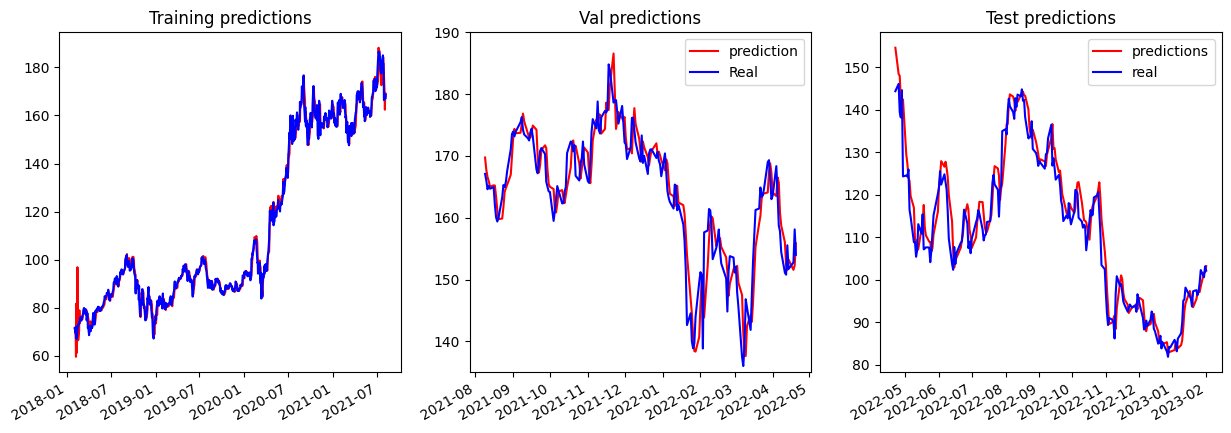

In [44]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(date_train[1:], y_train_pred, color='red')
ax1.plot(date_train[1:],y_train[1:], color='blue')
ax1.set_title('Training predictions')

ax2.plot(date_val,y_val_pred, color='red', label = 'prediction')
ax2.plot(date_val,y_val, color='blue', label='Real')
ax2.set_ylim(135,190)
ax2.set_title('Val predictions')
ax2.legend()

ax3.plot(date_test,y_test_pred, color='red', label='predictions')
ax3.plot(date_test,y_test, color='blue', label='real')
ax3.set_title('Test predictions')
ax3.legend()

fig.autofmt_xdate()

plt.show()
plt.close()

### Evaluate results

To evaluate the results of the predictions, we will use the Mean Absolute Error. You can also consider other metrics.

In [45]:
train_mae = mean_absolute_error(y_train_pred, y_train[1:])
val_mae = mean_absolute_error(y_val_pred, y_val)
test_mae = mean_absolute_error(y_test_pred , y_test)

print("Train MAE = {}".format(train_mae))
print("Val  MAE = {}".format(val_mae))
print("Test  MAE = {}".format(test_mae))

Train MAE = 1.9529777337635905
Val  MAE = 2.9147338111908474
Test  MAE = 3.177004331826902


Notice that the MAE of the validation and test set is significantly higher than the training MAE. This indicates that the QRC is slighlty overfitting the training data. The regularization parameter $\alpha$, among other hyperparameters of the model, could help reduce this overfitting.

## Changing the unitary

In the previous example we used a random unitary matrix to determine the evolution of the quantum states. However, there are usually better ways of designing the quantum reservoirs.
A commonly used unitary transformation is the evolution under the transverse field Ising model, $\displaystyle U = e^{-i\hat{H}_{\text{Ising}} t}$, whose Hamiltonian is
%
\begin{equation}
    \hat{H}_{\text{Ising}} = \sum_{i>j=0}^{N-1} J_{ij} Z_iZ_j + \sum_{i}^{N-1} h X_i, \quad J_{ij}, h \in \mathbb{R}.
\end{equation}

where $N$ is the number of spins, $h$ is the external magnetic field and $J_{ij}$ are the spin-spin couplings.  The coefficients $J_{ij}$ are sampled uniformly from $[-J_s/2, J_s/2]$.

This Hamiltonian presents a phase transition, from a localized regime, where the level spacing of the eigenenergies follows a Poisson distribution, and an ergodic phase, where the level spacing follows a Wigner distribution. Interestingly, the best use of quantum reservoirs happens close to the phase transition, roughly when $h = 0.1 J_s$.

Let us implement the time evolution of the Ising Hamiltonian until time $t=10$. For simplicity, we generate such Hamiltonian for $N+n=4$ qubits. You can later generalize this Hamiltonian to use a different number of qubits.

In [46]:
J = 0.75
t = 10
nqbits = meas_qbits = 3
alpha = 1e-3

def get_unitary(J = 0.75, t=10):
    Js = np.random.uniform(-J/2,J/2, size = 6)
    h = J*0.1
    # Interaction Hamiltonian
    H_inter = SparsePauliOp(["XXII", "XIXI", "IXXI", "XIIX", "IXIX", "IIXX"], coeffs = [Js[0], Js[1],Js[2], Js[3], Js[4], Js[5]])   #Js[0]*(X^X^I^I) + Js[1]*(X^I^X^I) + Js[2]*(I^X^X^I) + Js[3]*(X^I^I^X) + Js[4]*(I^X^I^X) + Js[5]*(I^I^X^X)
    # Magnetic Field Hamiltonian
    H_magnetic = SparsePauliOp(["ZIII","IZII","IIZI","IIIZ" ], coeffs = [h,h,h,h]) #h*(Z^I^I^I) + h*(I^Z^I^I) + h*(I^I^Z^I) + h*(I^I^I^Z)
    # Ising Hamiltonian
    H_Ising = H_inter + H_magnetic

    # Constructing the evolition operator U = exp(-iHt)
    evol_gate = PauliEvolutionGate(H_Ising, time=t, synthesis=SuzukiTrotter())
    evolved_state = QuantumCircuit(nqbits+1)
    evolved_state.append(evol_gate, [0,1,2,3])

    # Get unitary from circuit
    U = Operator(evolved_state).data
    return U
U = get_unitary(J,t)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [47]:
y_train_pred, lm, rho, X_trainQ, observables = train_QRC(y_train_scaled, scaler, nqbits, meas_qbits, alpha)
y_val_pred, rho, X_trainQ, y_trained_model = test_QRC(y_val_scaled, rho, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_train_scaled[1:])
y_test_pred, rho, X_trainQ, y_trained_model = test_QRC(y_test_scaled, rho, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_trained_model)

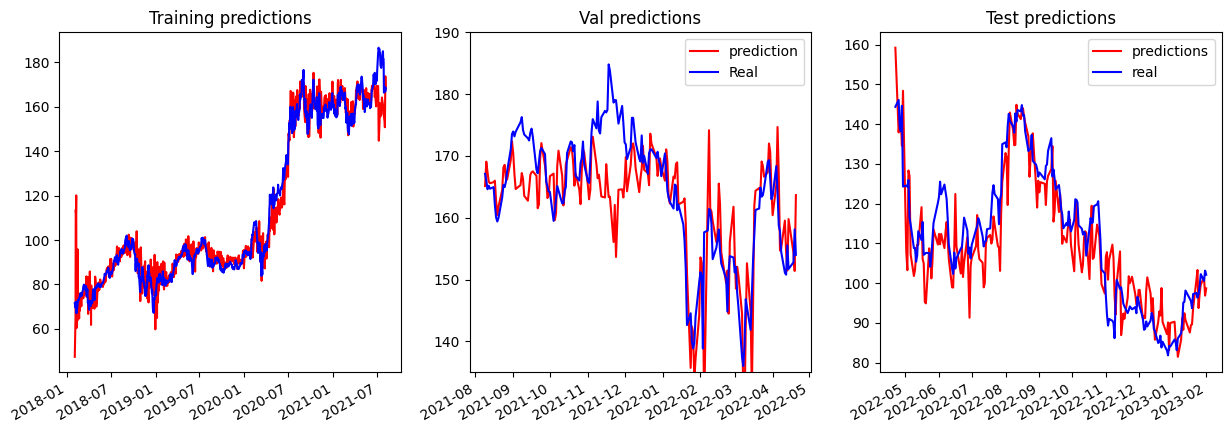

Train MAE = 4.464688722629288
Val  MAE = 5.031052168296813
Test  MAE = 6.155464156887354


In [48]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(date_train[1:], y_train_pred, color='red')
ax1.plot(date_train[1:],y_train[1:], color='blue')
ax1.set_title('Training predictions')

ax2.plot(date_val,y_val_pred, color='red', label = 'prediction')
ax2.plot(date_val,y_val, color='blue', label='Real')
ax2.set_ylim(135,190)
ax2.set_title('Val predictions')
ax2.legend()

ax3.plot(date_test,y_test_pred, color='red', label='predictions')
ax3.plot(date_test,y_test, color='blue', label='real')
ax3.set_title('Test predictions')
ax3.legend()

fig.autofmt_xdate()

plt.show()
plt.close()

train_mae = mean_absolute_error(y_train_pred, y_train[1:])
val_mae = mean_absolute_error(y_val_pred, y_val)
test_mae = mean_absolute_error(y_test_pred , y_test)

print("Train MAE = {}".format(train_mae))
print("Val  MAE = {}".format(val_mae))
print("Test  MAE = {}".format(test_mae))

## Exercise: Generalize the Ising model

We have seen that the Ising model can be used to generate quantum unitaries. The version we implemented only worked for 4 qubits. The tasks for this exercise are the following:
+ Generalize the previous function that generates unitaties based on the Ising model to more than 4 qubits.
+ Play with the hyperparameters of the model ($J_s$, $h$, $t$) and the QRC parameters (number of qubits $N$, regularization parameter $\alpha$). You may need to run several experiments with these configurations to draw statistically significant results. What configuration works better on average?



## Exercise: Generate different unitaries

Another way to generate the quantum unitary is by randomly sampling quantum gates from a fixed set. For example, consider the set that generates the Clifford group: {H, CNOT, S}. Given a maximum number of gates, you can generate random quantum circuits by randomly sampling the gates from this set. In this exercise, you are asked to generate quantum unitaries from two sets of gates:

+ {H, CNOT, S} (Generates the Clifford Group)

+ {H, CNOT, T} (Universal set of gates)

Test the performance of the QRC model with these quantum transformations for different number of gates and different number of qubits. Which gate set works best for this example?

## Quantum Reservoir Computing with noise

Real quantum systems suffer from interactions with the world surrounding them, which produce noisy experimental results. Understanding the noise mechanisms and learning how to control them is key to building useful quantum algorithms. Understanding the noise mechanisms and learning how to control them is key to building useful quantum algorithms.

In this example, we will create a toy model of a noisy quantum reservoir. While this setting will not be realistic in actual quantum devices, it gives us a rough idea of how quantum noise affects our measurements. Let's look at a very common type of error: the depolarizing noise.

The depolarizing channel can be described by saying that, with probability $1-p$ the qubit remains untouched, while with probability $p$ an error occurs. The error can be, with equal probability, one of these three:


+ Bit-flip error: $\ket{\psi} \rightarrow X \ket{\psi}$,
+ Phase-flip error: $\ket{\psi} \rightarrow Z \ket{\psi}$,
+  Both bit-flip and phase-flip errors: $\ket{\psi} \rightarrow Y \ket{\psi}$.


Thus, if an error occurs, the initial state $\ket{\psi}$ evolves to an ensemble of the three states: $X\ket{\psi}, Y\ket{\psi}, Z\ket{\psi}$. Given an initial state $\rho$, the depolarizing noise transforms this state to:

  \begin{equation}
     \epsilon(\rho) = (1-p)\rho + \frac{p}{3}(X\rho X + Y \rho Y + Z \rho Z) = (1-p) \rho + \frac{p}{d} \mathbb{I}.
 \end{equation}

Notice that the depolarizing channel transforms the state $\rho$ to the maximally mixed state with probability $p$.

The following code implements the depolarizing channel to a quantum state $\rho$. Look at how changing the value of $p$ alters the performance of QRC.


In [49]:
p = 0.99
def apply_depolarizing(p, rho):
    d = rho.shape[0]
    return (1-p)*rho + p/d*np.eye(rho.shape[0], dtype=rho.dtype)

def compute_evolution(U, rho):
    rho_noiseless = U.conj().T @ rho @ U
    rho_noisy = apply_depolarizing(p, rho_noiseless)
    return rho_noisy


In [50]:
y_train_pred, lm, rho, X_trainQ, observables = train_QRC(y_train_scaled, scaler, nqbits, meas_qbits, alpha)
y_val_pred, rho, X_trainQ, y_trained_model = test_QRC(y_val_scaled, rho, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_train_scaled[1:])
y_test_pred, rho, X_trainQ, y_trained_model = test_QRC(y_test_scaled, rho, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_trained_model)

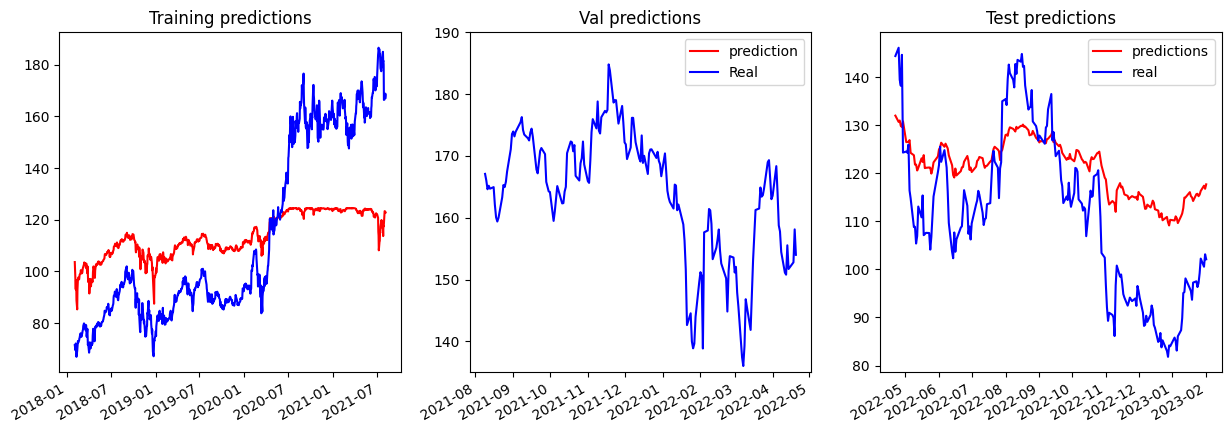

Train MAE = 24.882497981518355
Val  MAE = 35.575161966073495
Test  MAE = 12.676101234148389


In [51]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(date_train[1:], y_train_pred, color='red')
ax1.plot(date_train[1:],y_train[1:], color='blue')
ax1.set_title('Training predictions')

ax2.plot(date_val,y_val_pred, color='red', label = 'prediction')
ax2.plot(date_val,y_val, color='blue', label='Real')
ax2.set_ylim(135,190)
ax2.set_title('Val predictions')
ax2.legend()

ax3.plot(date_test,y_test_pred, color='red', label='predictions')
ax3.plot(date_test,y_test, color='blue', label='real')
ax3.set_title('Test predictions')
ax3.legend()

fig.autofmt_xdate()

plt.show()
plt.close()

train_mae = mean_absolute_error(y_train_pred, y_train[1:])
val_mae = mean_absolute_error(y_val_pred, y_val)
test_mae = mean_absolute_error(y_test_pred , y_test)

print("Train MAE = {}".format(train_mae))
print("Val  MAE = {}".format(val_mae))
print("Test  MAE = {}".format(test_mae))

You may have seen that unless you increase the error probability to a value very close to 1, the performance of the QRC model does not decrease. This is because, even though a lot of information is lost with the noise channel, the ML model is still able to retrieve the useful information.

This may lead you to think that noise is not actually a big enemy in quantum algorithms. However, in our toy model we have only applied the noise model once, after the whole unitary was applied. In real settings, the noise model would be applied after each quantum gate! Also, the error is different for different quantum gates (two-qubit quantum gates produce higher errors). There are also measurement erros that need to be taken into account... so in reality quantum noise is a big problem for mantaining the performance of quantum algorithms.

## Exercise: Create a more realistic noisy setting

To make this example look more realistic, you can apply the depolarizing noise after each quantum gate. That is, instead of creating only one quantum unitary, you can create $m$ unitaries $U_m$, where $m$ is the number of gates of the quantum circuit. Then, you would apply each unitary sequentially, and add the depolarizing noise after each $U_m$. Modify the QRC algorithm and test the performance with this method. Remember to decompose the quantum circuit with basic gates to obtain more accurate results.

You can check the basis gates for the IBM devices here: https://quantum.ibm.com/services/resources?tab=systems.

## Using quantum circuits

Now that we've seen how the QRC works theoretically, let's move to a more practical example. We will re-do the code by encoding the quantum reservoir in a quantum circuit, instead of using the density matrix formalism.

## 1. Initialize the quantum circuit

To initialize the quantum circuit, we will encode the input data using angle encoding to the first $L$ qubits. We initialize the rest of the qubits in a superposition by applying a Hadamard gate to each qubit.

In [52]:
y_train_scaled = y_train_scaled.reshape(-1,1)
y_val_scaled = y_val_scaled.reshape(-1,1)
y_test_scaled = y_test_scaled.reshape(-1,1)


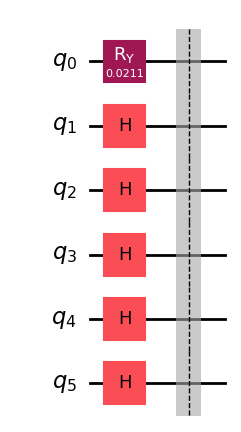

In [53]:
nqbits = 5
meas_qubits = 2
L = y_train_scaled.shape[1]
t = 0

def initial_state_circuit(y, nqbits = 5, L = 1, time = 0):
  qc = QuantumCircuit(nqbits+L)
  # Initalize quantum state y to first L qubits
  for i in range(L):
    qc.ry(y[time, i], i)
  # Initialize the rest of the qubits with Hadamard gates
  for i in range(L, nqbits + L):
    qc.h(i)
  qc.barrier()
  return qc

initial_state = initial_state_circuit(y_train_scaled, nqbits, L, t)
initial_state.draw('mpl')


## 2. Quantum reservoir

The quantum will be a quantum circuit with random operations. In this case, let's apply rotations with random angles and a circular entanglement layer.

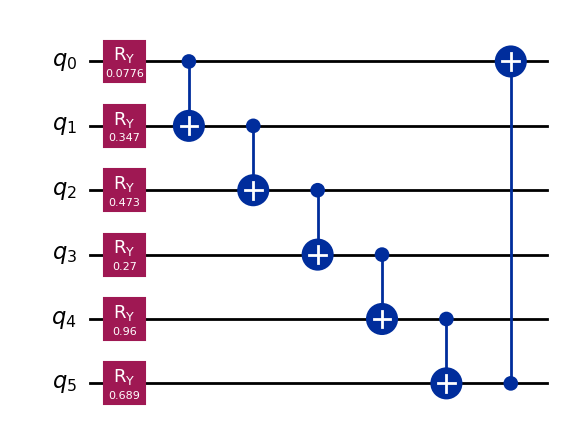

In [54]:
# As a simple example
def get_unitary_circuit(nqbits = 5, L = 1):
    circ = QuantumCircuit(nqbits + L)
    for i in range(nqbits + L):
        theta = np.random.rand(1)[0]
        circ.ry(theta,i)
    for i in range(nqbits + L):
        circ.cx(i, (i+1)%(nqbits + L))
    return circ
qc_U = get_unitary_circuit(nqbits, L)
qc_U.draw('mpl')


## 3. Evolve the initial state

In this case, we just need to compose the two quantum circuits encoding the input data and the quantum reservoir.

In [55]:
def compute_evolution_circuit(initial_state, qc_U):
    qc = initial_state.compose(qc_U)
    qc.barrier()
    return qc
# Compute evolution under unitary
qc = compute_evolution_circuit(initial_state, qc_U)


## 4. Define observables to measure

Just like before, we measure the expected value of local operators

In [56]:
from qiskit.quantum_info import Pauli, SparsePauliOp

def get_observables(meas_qubits = 5, nqbits = 5, L = 1):
    observables = []
    for i in range(meas_qubits+1):
        name_Z = 'I'*(nqbits+1)
        name_Z = Pauli(name_Z[:i] + 'Z' + name_Z[i + 1:])
        name_X = 'I'*(nqbits+1)
        name_X = Pauli(name_X[:i] + 'X' + name_X[i + 1:])
        observables.append(name_Z)
        observables.append(name_X)
    return observables
observables = get_observables(meas_qubits, nqbits)


## 5. Obtain measurements

Measure the measurement qubits to obtain the input data to the classical ML model. You can use a quantum simulator or an actual quantum device.

In [57]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

backend = AerSimulator()  # ideal simulator
estimator = Estimator(backend)

def get_measurements(qc, observables):
    meas = estimator.run([(qc, observables)]).result()[0].data.evs
    return np.array(meas)
results =  get_measurements(qc, observables)

## 6. Re-initialize input qubits

Reset and initialize the input qubits with the new data point.

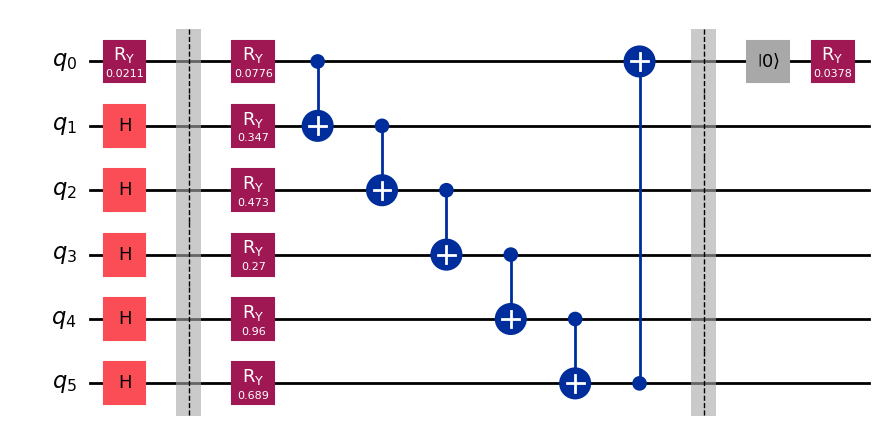

In [58]:
def re_initialize(qc, y, L, t):
  for i in range(L):
    qc.reset(i)
    qc.ry(y[t, i], i)
  return qc
t += 1
qc = re_initialize(qc, y_train_scaled, L, t)
qc.draw('mpl')

## Alltogether

Let's introduce a cooling period $k$. That is, we will discard the first $k$ measurements to train the classical linear regression model, so that these outputs are not dependent on the circuit initial states.

Also, we will implement a rolling window with a `batch_size`, so that we keep the depth of the circuit limited to the last few input data points. Because of the input forgetting property, this shouldn't affect the performance too much.

In [60]:
from tqdm import tqdm

backend = AerSimulator()  # ideal simulator
estimator = Estimator(backend)

alpha = 1e-5
nqbits = 5
meas_qbits = 5
L = y_train_scaled.shape[1]
batch_size = 5
k = 10

def train_QRC(y_train_scaled, scaler, nqbits=5, meas_qbits = 5, L =1, batch_size = 5, alpha=1e-5):
    t = 0
    # Initialization: Get initial state, quantum reservoir and observables
    qc = initial_state_circuit(y_train_scaled, nqbits, L, t)
    cut_initial = len(qc.data)
    qc_U = get_unitary_circuit(nqbits, L)
    cut_U = len(qc_U.data)
    observables = get_observables(meas_qbits, nqbits, L)
    # Vector of quanutm features
    X_trainQ = np.zeros((y_train_scaled.shape[0]-1, len(observables)))
    # Initial Hadamard circuit
    qc2 = QuantumCircuit(nqbits+L)
    # Initialize the rest of the qubits with Hadamard gates
    for i in range(L, nqbits + L):
      qc2.h(i)
    ## Get observables for all data samples
    for i in tqdm(range(1,y_train_scaled.shape[0])):
        # Rolling window, keep only the last 5 circuits
        if i > batch_size+1:
          del qc.data[:(cut_initial + cut_U)]
          qc = qc2.compose(qc)
          cut_initial = nqbits + L + 2
        # Compute evolution under unitary
        qc = compute_evolution_circuit(qc, qc_U)
        # Compute measurements
        X_trainQ[i-1] = get_measurements(qc, observables)
        # Re-initialize quantum state
        t += 1
        qc = re_initialize(qc, y_train_scaled, L, t)

    # Fit Ridge regression
    lm = Ridge(alpha=alpha)
    # Discard K initial steps
    lm.fit(X_trainQ[k:], y_train_scaled[(k+1):].reshape(-1,1))
    y_train_pred = lm.predict(X_trainQ[k:])
    y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
    return y_train_pred, lm, qc, qc_U, X_trainQ, observables

y_train_pred, lm, qc, qc_U, X_trainQ, observables = train_QRC(y_train_scaled, scaler, nqbits=5, meas_qbits = 5, L =1, batch_size = 5, alpha=1e-5)

100%|██████████| 884/884 [10:30<00:00,  1.40it/s]


In [61]:
def test_QRC(y, qc, qc_U, observables, scaler, lm, retrain=True, X_trainQ = None, y_train=None):
    X_train = X_trainQ
    y_train_scaled = y_train
    t=0
    y_pred = []
    cut_initial = nqbits + L + 2
    cut_U = len(qc_U.data)

    # Initial Hadamard circuit
    qc2 = QuantumCircuit(nqbits+L)
    # Initialize the rest of the qubits with Hadamard gates
    for i in range(L, nqbits + L):
      qc2.h(i)
    # Making the predictions!
    for i in tqdm(range(0,y.shape[0])):
        # Rolling window, keep only the last 5 circuits
        del qc.data[:(cut_initial + cut_U)]
        qc = qc2.compose(qc)
        # Compute evolution under unitary
        qc = compute_evolution_circuit(qc, qc_U)

        # Compute measurements
        X_testQ = get_measurements(qc, observables)
        # Predict with Ridge regression
        y_hat = lm.predict(X_testQ.reshape(1,-1)) #Predict with ridge regression
        y_hat[y_hat<0] = 0 # Check that the predicted value is in [0,1]
        y_hat[y_hat>1] = 1
        y_hat = scaler.inverse_transform(y_hat.reshape(1,-1)).flatten() # Reescale prediction
        y_pred.append(y_hat)

        # Re-initialize quantum state
        qc = re_initialize(qc, y, L, t)
        t += 1
        # Retrain the model for future predictions
        if retrain:
            X_train = np.vstack((X_train, X_testQ))
            y_train_scaled = np.vstack((y_train_scaled.reshape(-1,1), y[i].reshape(1,1)))
            lm.fit(X_train, y_train_scaled)
    y_pred = np.array(y_pred)
    return y_pred, qc, X_train, y_train_scaled

y_val_pred, qc, X_trainQ, y_trained_model = test_QRC(y_val_scaled, qc, qc_U, observables, scaler, lm, X_trainQ = X_trainQ[k:], y_train = y_train_scaled[(k+1):])
y_test_pred, qc, X_trainQ, y_trained_model = test_QRC(y_test_scaled, qc, qc_U, observables, scaler, lm, X_trainQ = X_trainQ, y_train = y_trained_model)

100%|██████████| 196/196 [02:16<00:00,  1.44it/s]


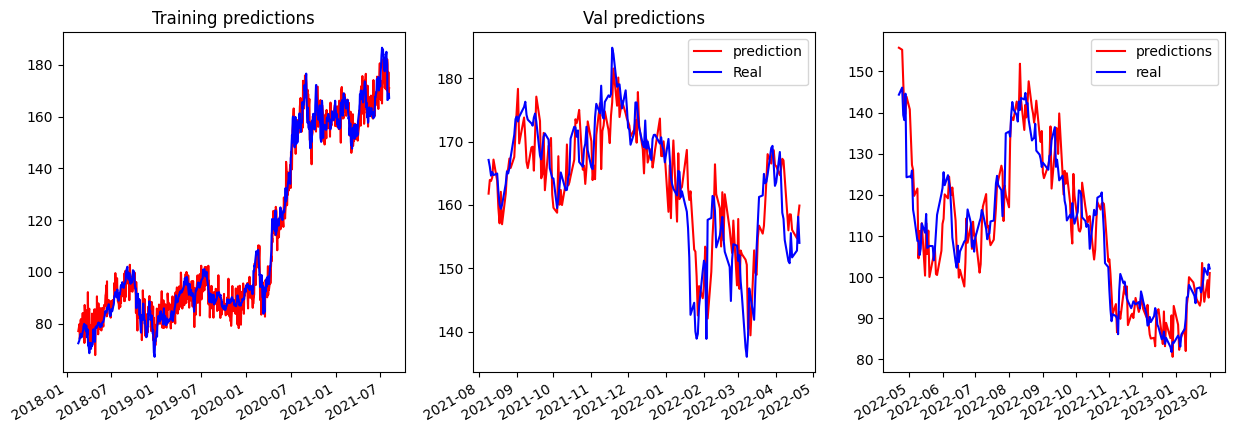

In [62]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(date_train[(k+1):], y_train_pred, color='red')
ax1.plot(date_train[(k+1):],y_train[(k+1):], color='blue')
ax1.set_title('Training predictions')

ax2.plot(date_val,y_val_pred, color='red', label = 'prediction')
ax2.plot(date_val,y_val, color='blue', label='Real')
#ax2.set_ylim(135,190)
ax2.set_title('Val predictions')
ax2.legend()

ax3.plot(date_test,y_test_pred, color='red', label='predictions')
ax3.plot(date_test,y_test, color='blue', label='real')
#ax3.set_title('Test predictions')
ax3.legend()

fig.autofmt_xdate()

plt.show()
plt.close()

In [63]:
train_mae = mean_absolute_error(y_train_pred, y_train[(k+1):])
val_mae = mean_absolute_error(y_val_pred, y_val)
test_mae = mean_absolute_error(y_test_pred , y_test)

print("Train MAE = {}".format(train_mae))
print("Val  MAE = {}".format(val_mae))
print("Test  MAE = {}".format(test_mae))

Train MAE = 4.044069091765766
Val  MAE = 4.326588619414568
Test  MAE = 5.022192107383612


## Exercise
How does the performance of this method compare with the classical simulation using the density matrix formalism? Try changing the design of the quantum reservoir, the rolling window lenght and other hyperparameters of the system.